Este es un cuaderno complementario del libro [Aprendizaje profundo con Python, segunda edición](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff).

## Traduccion automatica usando transformers

### Recoleccion de datos



In [1]:
text_file1 = "esp.txt" 
text_file2 = "que.txt"

with open(text_file1) as f:
    lines1 = f.read().split("\n")[:-1]
with open(text_file2) as f:
    lines2 = f.read().split("\n")[:-1]
text_pairs = [] 

for i in range(0,len(lines2)):
    español  = lines1[i]
    quechua  = lines2[i]
    if español != quechua:
       quechua = "[start] " + quechua + " [end]"
       text_pairs.append((español, quechua))

In [2]:
import random
print(random.choice(text_pairs))

('Artículos de estudio 1 y 2 PÁGINAS 8 - 16', '[start] 1 , 2 ukhunchanapaq yachaqanas 8 - 16 PAGINASPI [end]')


In [3]:
import random
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples:]

**Vectorizando los pares de texto en español y quechua**

In [4]:
import tensorflow as tf
from tensorflow.keras import layers
import string
import re

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

vocab_size = 15000
sequence_length = 20

source_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
target_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_spanish_texts = [pair[0] for pair in train_pairs]
train_quechua_texts = [pair[1] for pair in train_pairs]
source_vectorization.adapt(train_spanish_texts)
target_vectorization.adapt(train_quechua_texts)

**Preparing datasets for the translation task**

In [5]:
batch_size = 100

def format_dataset(spa, que):
    spa = source_vectorization(spa)
    que = target_vectorization(que)
    return ({
        "español": spa,
        "quechua": que[:, :-1],
    }, que[:, 1:])

def make_dataset(pairs):
    spa_texts, que_texts = zip(*pairs)
    spa_texts = list(spa_texts)
    que_texts = list(que_texts)
    dataset = tf.data.Dataset.from_tensor_slices((spa_texts, que_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [7]:
for inputs, targets in train_ds.take(1):
    print(f"inputs['español'].shape: {inputs['español'].shape}")
    print(f"inputs['quechua'].shape: {inputs['quechua'].shape}")
    print(f"targets.shape: {targets.shape}")

inputs['español'].shape: (100, 20)
inputs['quechua'].shape: (100, 20)
targets.shape: (100, 20)


### Sequence-to-sequence learning with Transformer

In [8]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential([layers.Dense(dense_dim, activation="relu"),layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

#### The Transformer decoder

**The `TransformerDecoder`**

In [9]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential([layers.Dense(dense_dim, activation="relu"),layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat([tf.expand_dims(batch_size, -1),tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        attention_output_1 = self.attention_1(query=inputs,value=inputs,key=inputs,attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(query=attention_output_1,value=encoder_outputs,key=encoder_outputs,attention_mask=padding_mask,)
        attention_output_2 = self.layernorm_2(attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

#### Putting it all together: A Transformer for machine translation

**PositionalEmbedding layer**

In [10]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

**End-to-end Transformer**

In [11]:
import keras
embed_dim = 256
dense_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="español")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="quechua")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [12]:
transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
transformer.fit(train_ds, epochs=1, validation_data=val_ds)

107/107 [==============================] - 432s 4s/step - loss: 3.6105 - accuracy: 0.1835 - val_loss: 2.8021 - val_accuracy: 0.2578


**Training the sequence-to-sequence Transformer**

In [13]:
import numpy as np
spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

test_spa_texts = [pair[0] for pair in test_pairs]
for _ in range(20):
    input_sentence = random.choice(test_spa_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

-
Cómo hablar de sexo con los hijos , 1 / 11
[start] 3 paginapi [end]
-
a ) ¿ Quién nos ha revelado cómo es el Creador ?
[start] a imaynatá imaynatá [end]
-
“ Continúen soportándose unos a otros y perdonándose liberalmente unos a otros ” ( Colosenses 3 : 13 ) .
[start] [ 4 paginapi dibujo foto ] [end]
-
□ Marcos 14 : 12 - 16
[start] [ paginapi paginapi dibujo foto ] [end]
-
¿ Por qué diría usted que David fue un rey victorioso ?
[start] imaynatá imaynatá [end]
-
A visitar Betel , es decir , alguna de las 118 sucursales que los testigos de Jehová tienen en el mundo .
[start] a [UNK] [UNK] [UNK] [UNK] [end]
-
b ) ¿ Qué preguntas contestaremos ?
[start] b imaynatá [end]
-
Por ejemplo , estaban los lares y penates , que protegían a las familias , y la diosa Vesta , quien se ocupaba del fuego del hogar .
[start] kay [UNK] [UNK] [UNK] [UNK] [end]
-
En la Biblia se llama a Jesucristo “ el testigo fiel y verdadero ” .
[start] kay [UNK] [UNK] [UNK] [end]
-
¿ Qué había que hacer para entrar en e

## Precision del modelo

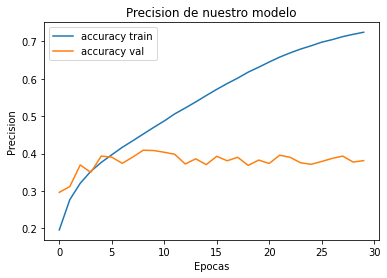

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

x = range(0,30)
x1 = [0.1960, 0.2768, 0.3209 , 0.3526, 0.3766, 0.3970, 0.4169, 0.4344, 0.4524, 0.4703 , 0.4874, 0.5064, 0.5220, 0.5384, 0.5554, 0.5719, 0.5875, 0.6020, 0.6180, 0.6312, 0.6451, 0.6582, 0.6695, 0.6798, 0.6885, 0.6981, 0.7049, 0.7129, 0.7191, 0.7247] 
x2 = [0.2965, 0.3120, 0.3697, 0.3499, 0.3935, 0.3906, 0.3741, 0.3908, 0.4092, 0.4083, 0.4037, 0.3983, 0.3723, 0.3861, 0.3707, 0.3928, 0.3810, 0.3903, 0.3686, 0.3828, 0.3737, 0.3959, 0.3900, 0.3755, 0.3715, 0.3790, 0.3873, 0.3934, 0.3775, 0.3813]
#Generamos una grafica lineal para una recta en X
plt.plot(x, x1, label='accuracy train')
#Generamos otra grafica lineal para una X cuadratica
plt.plot(x, x2, label='accuracy val')
#Agregamos las etiquetas y añadimos una leyenda.
plt.xlabel('Epocas')
plt.ylabel('Precision')
plt.title("Precision de nuestro modelo")
plt.legend()
plt.savefig('grafica_lineal.png')
plt.show()